# Moon Landing Training

We begin by importing the important libraries that will be used. In this case, we need:
- `deque` for the data structrue used for memory buffer
- `namedtuple` for storing the experience tuples
- `gym` is ued to test reinforcement learning (0.24.0)
- `PIL.image` and `pyvirtualdisplay` are used to render the Lunar Lander Environment

In [19]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import utils

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [2]:
# Set up a virtual display to render the Lunar Lander environment.
Display(visible=0, size=(840, 480)).start();
# Set the random seed for TensorFlow
tf.random.set_seed(utils.SEED)

# Hyperparameters

In [3]:
MEMORY_SIZE = 100_000 #SIZE OF THE MEMORY BUFFER / Replay Buffer
GAMMA = 0.995 #DISCOUNT FACTOR
ALPHA=1e-3 #LEARNING RATE
NUM_STEPS_FOR_UPDATE=4 #NUMBER OF STEPS TO UPDATE THE TARGET NETWORK, every C steps

# Lunar Lander Environment

The OpenAI Gym environment provides LunarLander environment, which is simply a task or problem we want to solve. We will solve Lunar Lander by Reinforcement Learning.
<br>
<figure>
  <img src = "images/lunar_lander.gif" width = 40%>
  <br>
  <br>
      <figcaption style = "font-style: italic">Fig 1. Lunar Lander Environment.</figcaption>
</figure>

# Rules
- The two flag poles surround the center 0,0 of the landing pad
- Lander is allowed to land outside landing pad
- Lander starts at the top center of the environment
- Fuel is cheap (infinite)
- Need 200 points to win

### Actions
Agent takes 1 of 4 actions:
- 0 - Do nothing
- 1 - Right
- 2 - Main
- 3 - Left

### State vector
The agent's observation space is as follows:
- (x,y) coordinates
- (x´,y´) the linear velocities
- (θ) the angle
- (θ´) the angular velocity (***shudders in 105 Dynamics***)
- L,R -> 2 booleans to show whether the leg is touching ground or not

### Reward
For each step, the reward:

- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.
- The episode receives an additional reward of -100 or +100 points for crashing or landing safely respectively.

### The Agent
The agent is the entity that learns from interactions with the environment. It makes decisions based on the state of the environment, attempting to achieve a goal. In the case of the Lunar Lander:

**Goal**: Safely land the lunar lander on the landing pad.

**Decision-making**: The agent decides at each time step which action to take from the set of available actions (do nothing, fire right engine, fire main engine, fire left engine).

### The Environment
The environment encompasses everything external to the agent that the agent interacts with. This includes the lunar lander's dynamics, the moon's surface, the landing pad, and the laws of physics that govern how actions affect the state of the lander. In RL, the environment is responsible for:
- Providing state information to the agent: at each time step, the environment supplies the agent with the current state, which includes the lander’s position, velocity, angle, angular velocity, and whether each leg is touching the ground.
- Responding to the agent's actions: After an action is taken by the agent, the environment transitions to a new state and provides feedback in the form of a reward signal.

### Interaction Process
- Observation Space: The state vector provided by the environment to the agent. For the Lunar Lander, this includes spatial coordinates, velocities, and contact points.
- Action Space: The set of all possible actions the agent can take. In this environment, these actions control the lander’s engines.
- Rewards: Positive and negative feedback provided to guide the agent's learning. Rewards in the Lunar Lander are based on proximity to the target, movement speed, orientation, and successful landing or penalties for crashing.
- Episode Termination: Conditions under which the current episode (or trial) ends. This could be when the lander lands or crashes, or when it moves out of the designated horizontal boundaries.

### Learning and Optimization
The agent learns an optimal policy — mapping `states` to `actions` — through repeated interaction with the environment, guided by the reward signals. The agent aims to maximize the cumulative reward over time, which, in this scenario, would mean learning how to land the lander safely and efficiently. Various RL algorithms can be employed to learn this policy, such as Q-learning, deep Q-networks (DQN), or policy gradient methods, depending on the specific requirements and characteristics of the problem and the available data.

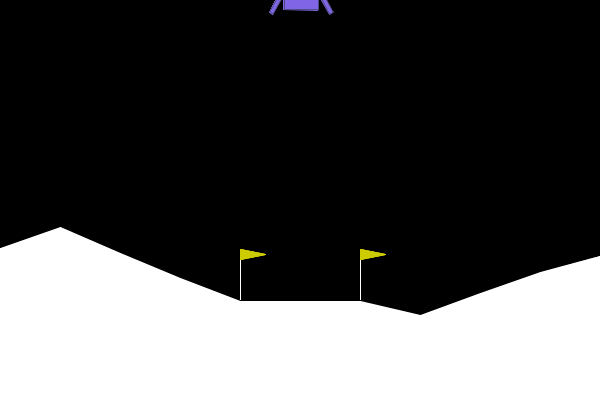

In [4]:
env = gym.make('LunarLander-v2',render_mode="rgb_array")
env.reset()
PIL.Image.fromarray(env.render())

In [5]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


<figure>
  <image src = "images/rl_formalism.png" width = 100%>
  <br>
  <br>
</figure>
Above shows agent-environment loop. Here:
<ul>
<li> Agent interacts with environment in discrete steps t=0,1,2,3...
<li> Each step t, agent uses policy π to select action A_t based on current state S_t
<li> Agent receives reward R_t
<li> Next time step is the new state S_(t+1)

The `.step()` method runs a single time step in environment. It accepts as parameter one action and returns 4 values:
- ``observation`` *object* :This is the state matrix, or the observation space array. 
- ``reward`` *float*       :This is the amount of reward given
- ``done`` *boolean*       :This is True when it's time to reset (crashed or landed)
- ``info`` *dictionary*    :Unused in this case, but useful debugging info.

In [6]:
#Reset environment and get initial state
initial_state=env.reset()

# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done, info,_ = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Initial State:", initial_state[0])
    print("Action:", action)
    print("Next State:", next_state)
    print("Reward Received:", reward)
    print("Episode Terminated:", done)
    print("Info:", info)

# Replace the `current_state` with the state after the action is taken
initial_state = next_state

Initial State: [-0.006 1.411 -0.653 0.023 0.007 0.148 0.000 0.000]
Action: 0
Next State: [-0.013 1.411 -0.652 -0.002 0.015 0.146 0.000 0.000]
Reward Received: -0.6006887917977792
Episode Terminated: False
Info: False


/Users/alies/Desktop/University/Projects/Deep Q Learning- Landing on the Moon/lunarlanding/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# Deep Q Learning
When both the state and action space are discrete we can estimate the action-value function iteratively by using the Bellman equation:

$$
Q\underbrace{(s,a)}_{x} = \underbrace{R(s) + \gamma \max_{a'}Q(s',a')}_{y}
$$
Here, Q(s,a) is the return if you start in state s, take action a, then behave optimally after that. π(s)=a where a is $max_{a}Q(s,a)$. This only works if you can compute Q(s,a) for every action. 
Note that ${s'}$ means the new state we got to after taking action $a$. The prime represents new action/new state.

The above bellman equation is similar to 
$$
f_{w,b}(x)≈y
$$
Getting the actual (x,y) points is simple. We do random actions and get various states. Based on these states, we determine x as the (**state,action**) tuple, and y as the right hand side of the bellman equation, as determined by R(s) and S, both of which are given.

<img src='images/GettingXY.jpg' width=40%><br>

Above, we see that y is determined by R(s) + $ \gamma\ $ times the max of the Q of...pay attention... the new reached state having taken action $a$. Now, how do we know what the maximum of Q is? We need to calculate Q for all possible actions in state $s^{'}$ to get the maximum. Since Q is recursive, initially we don't know what the Q function is. So at every step, Q here is some guess. 

Once we have above data, we train Neural Network to try to predict y as a function of the input x. 

The iterative method converges to the optimal action-value function Q*(s,a) as i-> $\infty$ 
- So the agent gradually explores the state-action space and updates the **estimate** of action-value function $Q(s,a)$ till it converges to optimal action-value function $Q^*(s,a)$
#### Problem
This works for regular discrete state space, but when it's continuous, it's impossible to explore the entire state-action space, and impossible to gradually estimate $Q(s,a)$ till its convergence

The solution is in **Deep Q Learning** wherein we solve the problem by using a neural network to estimate the action-value function $Q(s,a)≈Q^*(s,a)$
- This neural network is the Q-Network, trained by adjusting its weights to minimize mean-squared error in Bellman equation above
#### One more problem
Q-Networks are highly unstable. Instead, we use 
1. Target Network 
2. Experience Replay. 

# Target Network
We train the Q-Network by adjusting its weights at each iteration to minimize mean squared error. So here, the target value is
$$
y=R+\gamma\ max_{a'}Q(s',a';w)
$$
Here, $w$ are the weights of the Q-Network. This means that we adjust the weights $w$ for each iteration to $minimize$ the following error:
$$
\overbrace{\underbrace{R+\gamma\ max_{a'}Q(s',a';w)}_{\rm {y~target}} - Q(s,a;w)}^{\rm{Error}}
$$
#### Problem
Y target is changing over time and on every iteration. If the target is constantly changing, there are oscillations and instabilities. To avoid this, we create a separate neural network for generating the y-targets. This separate neural network is called **target $ \hat{Q}\ Network$**. 

Still following? To recap:
1. We use a neural network to create the optimal action-value function. 
2. To do that, we create another target neural network called $\hat{Q}$ Network with the same architecture as the original network. 

Now the equation becomes:
$$
\overbrace{\underbrace{R + \gamma \max_{a'}\hat{Q}(s',a'; w^-)}_{\rm {y~target}} - Q(s,a;w)}^{\rm {Error}}
$$

where $w^-$ and $w$ are the weights of the target-Q network and Q network, respectively.

In practice:
- Every $C$ time steps, we will use the $\hat{Q}$-Network to generate y targets and update the weights of the $\hat{Q}$-Network using the weights of the ${Q}$-Network.
- We will update the weights $w^-$ of the target network using a **soft update**.
This means updating the weights of $w^-$ using":
$$
w^-\leftarrow \tau w + (1 - \tau) w^-
$$

where $\tau \ll 1$. By using the soft update we ensure the target value $y$ changes slowly, which improves stability 

# Create the Q and Target $\hat{Q}$ Network
Deep-$Q$ Network -DQN- is a neural network that approximates the action-value function $Q(s,a)$ ≈ $Q^*(s,a)$. This is done by mapping states to $Q$ values. 

The algorithm is as follows:

Initialize randomly as a guess of Q(s,a)

Repeat:
-    Take actions in the lunar lander, getting (s,a,R(s),s')
-    Store 10,000 most recent (s,a,R(s),s') tuples ``Replay Buffer``
-    Train Neural Network:
        - Create training set of 10,000 (maybe less like 1000 random if you're doing mini-batch) examples -> x=(s,a) and y= R(s) + $\gamma\$ $max_{a'}$ Q(s',a')
        - Train $Q_{new}$ such that its ≈ y
- Set $Q$=$Q_{new}$ -> (sometimes we do $Q = 0.9Q + 0.1Q_{new}$ so that if the new neural network is worse than the old one, we do a soft update method)

See below:<br>

<img src='images/NeuralNetwork.jpg' width=50%>

In [7]:
q_network= Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear')
])

target_q_network= Sequential([
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear')
])

optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA)

# Experience Replay
As the agent interacts with the environment, the states, actions and rewards are all sequential. The agent **cannot** learn from them because the consecutive experiences have a strong correlation between them. To avoid, we use `Experience Replay` to generate uncorrelated experiences for training the agent. 

Experience Replay means storing agent's experience tuples $(S_t, A_t, R_t, S_{t+1})$ in a `memory buffer` at each time step. Then we sample a random mini-batch of experiences from the buffer to learn. 

In [8]:
experience=namedtuple('Experience',field_names=['state','action','reward','next_state','done'])

##### Deep Q-Learning with Experience Replay Algorithm
We use the following algorithm:
- Initialize memory buffer D with capcity N
- Initialize $Q$-Network with random weights w
- Initialize target $\hat{Q}$ with weights $w^-$ = $w$
- for episode i=1 to $M$ do
    - receive initial state $S_1$
    - for t=1 to *T* do
        - Observe state $S_t$ and choose action $a_t$ using an ɛ̝-greedy policy
            - This means with probability 0.95 or around there pick the action that maximizes $Q(s,a)$, `Greedy Exploitation`, and with a probability of 0.05≈$\epsilon$ pick action $a$ randomly, or `Exploration` 
        - Take action $a_t$, receive reward $R(t)$, move to $S_{t+1}$
        - Store experience tuple $(S_t, A_t, R(t), S_{t+1})$ in memory buffer D
        - Every $C$ steps perform a learning update:
        - Sample random mini-batch of experience tuples $(S_t, A_t, R(t), S_{t+1})$ from $D$
        - Set $y_j$ = $R_j$ if episode terminates at step j+1, otherwise set $y_i = R_j + \gamma\ max_{a'}\hat{Q}(s_{j+1},a^{'})$
        - Perform gradient descent step on ($y_j$ - $Q(s_j,a_j;W))^2$ with respect to the Q-Network weights w
        - Update the weights of the $\hat{Q}$-Network using a soft update
    - end 
- end

<a name="ex02"></a>
### Exercise 2

In this exercise you will implement line ***12*** of the algorithm:
> Set $y_j$ = $R_j$ if episode terminates at step j+1, otherwise set $y_i = R_j + \gamma\ max_{a'}\hat{Q}(s_{j+1},a^{'})$

 outlined in *Fig 3* above and you will also compute the loss between the $y$ targets and the $Q(s,a)$ values. In the cell below, complete the `compute_loss` function by setting the $y$ targets equal to:

$$
\begin{equation}
    y_j =
    \begin{cases}
      R_j & \text{if episode terminates at step  } j+1\\
      R_j + \gamma \max_{a'}\hat{Q}(s_{j+1},a') & \text{otherwise}\\
    \end{cases}       
\end{equation}
$$

Here are a couple of things to note:

* The `compute_loss` function takes in a mini-batch of experience tuples. This mini-batch of experience tuples is unpacked to extract the `states`, `actions`, `rewards`, `next_states`, and `done_vals`. You should keep in mind that these variables are *TensorFlow Tensors* whose size will depend on the mini-batch size. For example, if the mini-batch size is `64` then both `rewards` and `done_vals` will be TensorFlow Tensors with `64` elements.


* Using `if/else` statements to set the $y$ targets will not work when the variables are tensors with many elements. However, notice that you can use the `done_vals` to implement the above in a single line of code. To do this, recall that the `done` variable is a Boolean variable that takes the value `True` when an episode terminates at step $j+1$ and it is `False` otherwise. Taking into account that a Boolean value of `True` has the numerical value of `1` and a Boolean value of `False` has the numerical value of `0`, you can use the factor `(1 - done_vals)` to implement the above in a single line of code. Here's a hint: notice that `(1 - done_vals)` has a value of `0` when `done_vals` is `True` and a value of `1` when `done_vals` is `False`. 

Lastly, compute the loss by calculating the Mean-Squared Error (`MSE`) between the `y_targets` and the `q_values`. To calculate the mean-squared error you should use the already imported package `MSE`:

In [9]:
def compute_loss(experiences, gamma, q_network, target_q_network):
    '''
    Calculates the Mean Squared Error Loss
    Args:
        experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
        gamma: (float) The discount factor.
        q_network: (tf.keras.Sequential) Keras model for predicting the q_values
        target_q_network: (tf.keras.Sequential) Karas model for predicting the targets
    Returns:
        Loss: (Tf Tensor (shape=(0,)) 
        )
    '''
    #Unpack the mini-batch of tuples
    states,actions, rewards, next_states, done_vals = experiences
    
    #Compute max of Q(s,a)
    max_qsa=tf.reduce_max(target_q_network(next_states),axis=1)
    #above if you give like 10 states or 10X8, it will give 10 results or 10X4. But I only want to take max of each row, so axis=1 destroys all the columns into one. 
    y_target=rewards+((1-done_vals)*gamma*max_qsa)
    
    #compute the Q(s,a) or the current prediction (old)
    q_values= q_network(states)
    
    q_values= tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),tf.cast(actions,tf.int32)],axis=1))
    # so q_values is observed value and y_target is the target/predicted value
    loss = MSE(y_target, q_values)
    return loss

## 8 - Update the Network Weights

We will use the `agent_learn` function below to implement lines ***12 -14***:
> Set $y_j$ = $R_j$ if episode terminates at step j+1, otherwise set $y_i = R_j + \gamma\ max_{a'}\hat{Q}(s_{j+1},a^{'})$

> Perform gradient descent step on ($y_j$ - $Q(s_j,a_j;W))^2$ with respect to the Q-Network weights w

> Update the weights of the $\hat{Q}$-Network using a soft update

The `agent_learn` function will update the weights of the $Q$ and target $\hat Q$ networks using a custom training loop. Because we are using a custom training loop we need to retrieve the gradients via a `tf.GradientTape` instance, and then call `optimizer.apply_gradients()` to update the weights of our $Q$-Network. Note that we are also using the `@tf.function` decorator to increase performance. Without this decorator our training will take twice as long. 

The last line of this function updates the weights of the target $\hat Q$-Network using a [soft update](#6.1)

In [10]:
@tf.function
def agent_learn(experiences, gamma):
    '''
    Function to learn the Q-network
    Args:
        experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
        gamma: (float) The discount factor.
    '''
    #Calculate the loss
    with tf.GradientTape() as tape:
        loss=compute_loss(experiences,gamma,q_network, target_q_network)
    
    #Get the gradients of the loss with respect to the weight
    gradients=tape.gradient(loss, q_network.trainable_variables)
    
    #Update the weights of the network
    #Go through all the weights and apply the gradients to make it more accurate and minimize the loss
    #Our Adam optimizer tries to find the most efficient way down the error hill 
    #The zip function creates pairs between gradients and variables. Each pair corresponds to the gradient of the loss with respect to the variable. 
    
    # Apply gradients one by one
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))
    
    #Now I've updated the weights of the current q_network, but what about the target q_network?
    #update the weights of the target q_network using a soft update
    utils.update_target_network(q_network, target_q_network)
    '''
    The weights of the target_q_network are updated using the soft update rule:
                    w_target = (TAU * w) + (1 - TAU) * w_target

    where w_target are the weights of the target_q_network, TAU is the soft update
    parameter, and w are the weights of the q_network:
    
    for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)
'''
    

## Train the Agent

We are now ready to train our agent to solve the Lunar Lander environment. In the cell below we will implement the `Deep Q-Learning with Experience Relay` algorithm. 

* **Line 1**: We initialize the `memory_buffer` with a capacity of $N =$ `MEMORY_SIZE`. Notice that we are using a `deque` as the data structure for our `memory_buffer`.

* **Line 2**: We skip this line since we already initialized the `q_network` - when we created our neural network. 

* **Line 3**: We initialize the `target_q_network` by setting its weights to be equal to those of the `q_network`.

* **Line 4**: We start the outer loop. Notice that we have set $M =$ `num_episodes = 2000`. This number is reasonable because the agent should be able to solve the Lunar Lander environment in less than `2000` episodes.

* **Line 5**: We use the `.reset()` method to reset the environment to the initial state and get the initial state

* **Line 6**: We start the inner loop. Notice that we have set $T =$ `max_num_timesteps = 1000`. This means that the episode will automatically terminate if the episode hasn't terminated after `1000` time steps. It would otherwise terminate when the lunar lander crashes, or when it lands, or when it exits out of range. 

* **Line 7**: The agent observes the current `state` and chooses an `action` using an $\epsilon$-greedy policy. Our agent starts out using a value of $\epsilon =$ `epsilon = 1` which yields an $\epsilon$-greedy policy that is equivalent to the equiprobable random policy. This means that at the beginning of our training, the agent is just going to take random actions regardless of the observed `state`. As training progresses we will decrease the value of $\epsilon$ slowly towards a minimum value using a given $\epsilon$-decay rate. We want this minimum value to be close to zero because a value of $\epsilon = 0$ will yield an $\epsilon$-greedy policy that is equivalent to the greedy policy. This means that towards the end of training, the agent will lean towards selecting the `action` that it believes (based on its past experiences) will maximize $Q(s,a)$. We will set the minimum $\epsilon$ value to be `0.01` and not exactly 0 because we always want to keep a little bit of exploration during training

* **Line 8**: We use the `.step()` method to take the given `action` in the environment and get the `reward` and the `next_state`. 

* **Line 9**: We store the `experience(state, action, reward, next_state, done)` tuple in our `memory_buffer`. Notice that we also store the `done` variable so that we can keep track of when an episode terminates. This allowed us to set the $y$ targets.

* **Line 10**: We check if the conditions are met to perform a learning update. We do this by using our custom `utils.check_update_conditions` function. This function checks if $C =$ `NUM_STEPS_FOR_UPDATE = 4` time steps have occured and if our `memory_buffer` has enough experience tuples to fill a mini-batch. For example, if the mini-batch size is `64`, then our `memory_buffer` should have more than `64` experience tuples in order to pass the latter condition. If the conditions are met, then the `utils.check_update_conditions` function will return a value of `True`, otherwise it will return a value of `False`.


* **Lines 11 - 14**: If the `update` variable is `True` then we perform a learning update. The learning update consists of sampling a random mini-batch of experience tuples from our `memory_buffer`, setting the $y$ targets, performing gradient descent, and updating the weights of the networks. We will use the `agent_learn` function we defined to perform the latter 3.


* **Line 15**: At the end of each iteration of the inner loop we set `next_state` as our new `state` so that the loop can start again from this new state. In addition, we check if the episode has reached a terminal state (i.e we check if `done = True`). If a terminal state has been reached, then we break out of the inner loop.


* **Line 16**: At the end of each iteration of the outer loop we update the value of $\epsilon$, and check if the environment has been solved. We consider that the environment has been solved if the agent receives an average of `200` points in the last `100` episodes. If the environment has not been solved we continue the outer loop and start a new episode.

Finally, we wanted to note that we have included some extra variables to keep track of the total number of points the agent received in each episode. This will help us determine if the agent has solved the environment and it will also allow us to see how our agent performed during training. We also use the `time` module to measure how long the training takes. 

<br>
<br>
<figure>
  <img src = "images/deep_q_algorithm.png" width = 90% style = "border: thin silver solid; padding: 0px">
      <figcaption style = "text-align: center; font-style: italic">Fig 4. Deep Q-Learning with Experience Replay.</figcaption>
</figure>
<br>

In [130]:
start=time.time()
total_point_history=[]

num_episodes=2_000
max_num_iterations=1_000
MINIBATCH_SIZE = 64  # Mini-batch size.
E_DECAY = 0.995  # ε-decay rate for the ε-greedy policy.
E_MIN = 0.01  # Minimum ε value for the ε-greedy policy.
num_p_av=100

#Begin with completely random exploration
epsilon=1.0 # initial ε value for ε-greedy policy
memory_buffer=deque(maxlen=MEMORY_SIZE)
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    the_state=env.reset()
    total_points=0
    state=the_state[0]
    for t in range(max_num_iterations):
        state_qn=np.expand_dims(state,axis=0) #Get it to be a 1X8 matrix instead of an 8, array
        q_values=q_network(state_qn)
        
        ''' get_action function
        if random.random() > epsilon:
            return np.argmax(q_values.numpy()[0])
        else:
            return random.choice(np.arange(4))
        '''
        action=utils.get_action(q_values,epsilon)
        
        #Take action A, receive reward (R) and next state (S')
        next_state, reward, done, info,_ = env.step(action)
        
        #Store the experience tuple (S, A, R, S') in memory buffer, add done state as well
        memory_buffer.append(experience(state,action, reward, next_state, done))
        
        do_update= ( (t + 1) % NUM_STEPS_FOR_UPDATE == 0) and ( len(memory_buffer) > MINIBATCH_SIZE )
        
        if do_update:
            #Sample random mini-batch of experience tuples from Memory Buffer
            experiences=utils.get_experiences(memory_buffer)
            #Set y-targets, perform gradient descent, update and soft update Q and target Q
            agent_learn(experiences,GAMMA)
            
        state=next_state.copy()
        total_points +=reward
        
        if done:
            break
    total_point_history.append(total_points)
    av_latest_points=np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon= max(E_MIN, E_DECAY * epsilon)    
    
    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")
    
    # average of 200 points in the last 100 episodes.
    if av_latest_points>200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        
        #Saves the current state of the network in an HDF5 format. Capture a snapshot of a successfully trained model
        q_network.save('lunar_lander_model.h5')
        
        break
    
        
tot_time=time.time()-start
print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 54 | Total point average of the last 100 episodes: -126.69

KeyboardInterrupt: 

We can plot the total point history along with the moving average to see how our agent improved during training

In [ ]:
from tensorflow.keras.models import load_model

# Replace 'path_to_my_model.h5' with the path to your .h5 model file
q_network = load_model('lunar_lander_model.h5')

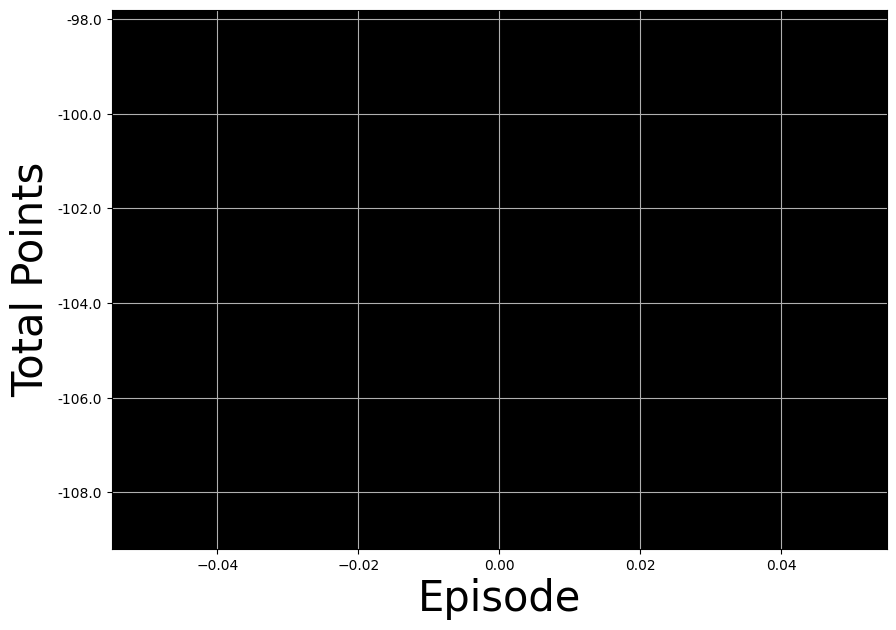

In [110]:
utils.plot_history(total_point_history)

## See the Trained Agent In Action

Now that we have trained our agent, we can see it in action. We will use the `utils.create_video` function to create a video of our agent interacting with the environment using the trained $Q$-Network. The `utils.create_video` function uses the `imageio` library to create the video. This library produces some warnings that can be distracting, so, to suppress these warnings we run the code below.

In [111]:
import logging
logging.getLogger().setLevel(logging.ERROR)

In the cell below we create a video of our agent interacting with the Lunar Lander environment using the trained q_network. The video is saved to the videos folder with the given filename. We use the utils.embed_mp4 function to embed the video in the Jupyter Notebook so that we can see it here directly without having to download it.

We should note that since the lunar lander starts with a random initial force applied to its center of mass, every time you run the cell below you will see a different video. If the agent was trained properly, it should be able to land the lunar lander in the landing pad every time, regardless of the initial force applied to its center of mass.

In [112]:
import importlib
import utils  # Ensure utils is imported

importlib.reload(utils)

<module 'utils' from '/Users/alies/Desktop/University/Projects/Deep Q Learning- Landing on the Moon/utils.py'>

In [113]:
import os
os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/bin/ffmpeg"  # Use your path

In [129]:
filename = "./videos/lunar_lander.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)

# Et Voila